In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import os
from os.path import exists
import cv2

from tensorflow.keras import layers, Model
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import pandas as pd
import ast
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks


from tensorflow.image import resize
from tensorflow.keras import utils


from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

2022-12-04 12:15:39.316776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 12:15:39.449600: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-04 12:15:39.452443: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 12:15:39.452454: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
# print("Hello")
# !pwd
from CustomGen import CustomGen
from tensorflow.keras.metrics import BinaryIoU
# import CustomGen

In [4]:
CustomGen

CustomGen.CustomGen

In [5]:
# Loss function (ref: https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html)
import tensorflow as tf

def custom_loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
      y_pred = tf.math.sigmoid(y_pred)
      numerator = 2 * tf.reduce_sum(y_true * y_pred)
      denominator = tf.reduce_sum(y_true + y_pred)

      return 1 - numerator / denominator

    y_true = tf.cast(y_true, tf.float32)
    o = tf.nn.sigmoid_cross_entropy_with_logits(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)

In [6]:
custom_loss

<function __main__.custom_loss(y_true, y_pred)>

In [7]:
from tensorflow.keras.models import load_model
pre_trained_model = load_model('../models/cp_model_11_3.h5', custom_objects={'custom_loss': custom_loss})
pre_trained_model


'''
# Retrieve the config
config = pre_trained_model.get_config()

# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"custom_loss": custom_loss}
with keras.utils.custom_object_scope(custom_objects):
    pre_trained_model = keras.Model.from_config(config)

'''

2022-12-04 12:15:43.309326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-04 12:15:43.309620: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/pi/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-04 12:15:43.309665: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/pi/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-04 12:15:43.309696: W tensorflow/compiler/xla/stream_exe

'\n# Retrieve the config\nconfig = pre_trained_model.get_config()\n\n# At loading time, register the custom objects with a `custom_object_scope`:\ncustom_objects = {"custom_loss": custom_loss}\nwith keras.utils.custom_object_scope(custom_objects):\n    pre_trained_model = keras.Model.from_config(config)\n\n'

In [8]:
# Paths definition after 
img_train_path = '../data/case1_tanks/input_image_train/'
mask_train_path = '../data/case1_tanks/output_mask_train/'

img_val_path = '../data/case1_tanks/input_image_val/'
mask_val_path = '../data/case1_tanks/output_mask_val/'

img_pred_path = '../data/case1_tanks/input_image_test/'
mask_pred_path = '../data/case1_tanks/output_mask_test/'

# Batch size
batch_size = 16

In [9]:
data_loader_pred = CustomGen(img_pred_path, mask_pred_path, batch_size)
data_loader_pred.__len__()
# CustomGen

8

In [10]:
# import os
# path_test = '../data/case1_tanks/input_image_test/'
# os.listdir(path_test)
# X_test = os.listdir(path_test)[0]

In [11]:
# def load_img(img_path):
#     img = np.array(utils.load_img(img_path,
#                          grayscale=False,
#                          color_mode='rgb',
#                          target_size=(256,256),
#                          interpolation='nearest'))
#     return img

In [12]:
def ret_contour(image_pred):
    image_8bit = np.uint8(image_pred * 255)
    ret, thresh = cv2.threshold(image_8bit, 127,255,0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     print(hierarchy)
    if hierarchy is not None:
        return contours, hierarchy[0]
    else:
        return contours, None

In [13]:

for i in range(len(data_loader_pred)):
    print ('batch '+str(i))    
    X_test, y_test, x_paths = data_loader_pred.__getitem__(i)
    
    #predicting y_pred
    y_pred = pre_trained_model.predict(X_test)
    
    #calculating contour
    
    
    #looping for y_pred
    for j in range(0, batch_size):
        #saving y_pred
        im = Image.fromarray((y_pred[j]*255).reshape(256, 256).astype(np.uint8))
        im.save('../data/case1_tanks/ouput_mask_pred/' + x_paths[j])
        
        # calculating contour
        X_test_tmp = (X_test[j].copy())*255
        contours, hierarchies = ret_contour(y_pred[j])
#         print(X_test_tmp.max())
        if len(contours)>0:
#             for contour, hierarchy in zip(contours, hierarchies):
#                 print (hierarchy)
#                 x,y,w,h = cv2.boundingRect(contour)
#                 cv2.rectangle(X_test_tmp,(x,y),(x+w,y+h),(255,0,0),2)
            for contour, hierarchy in zip(contours, hierarchies):
                if hierarchy[-1] == -1:          
                    x,y,w,h = cv2.boundingRect(contour)
                    cv2.rectangle(X_test_tmp,(x,y),(x+w,y+h),(255,0,0),2)
        im_contour = Image.fromarray((X_test_tmp).astype(np.uint8))
        im_contour.save('../data/case1_tanks/output_mask_final/' + x_paths[j])
        
#         plot_prediction(X_test, y_test, y_pred)

batch 0
1/1 [==============================] - 7s 7s/step
batch 1
1/1 [==============================] - 5s 5s/step
batch 2
1/1 [==============================] - 5s 5s/step
batch 3
1/1 [==============================] - 5s 5s/step
batch 4
1/1 [==============================] - 5s 5s/step
batch 5
1/1 [==============================] - 5s 5s/step
batch 6
1/1 [==============================] - 5s 5s/step
batch 7
1/1 [==============================] - 5s 5s/step


In [14]:
X_test_tmp

array([[[109., 101.,  80.],
        [108., 101.,  82.],
        [ 62.,  59.,  42.],
        ...,
        [192., 180., 158.],
        [192., 180., 158.],
        [192., 180., 158.]],

       [[198., 190., 169.],
        [153., 146., 127.],
        [ 81.,  75.,  59.],
        ...,
        [191., 179., 157.],
        [192., 180., 158.],
        [191., 179., 157.]],

       [[225., 214., 194.],
        [172., 165., 146.],
        [204., 198., 182.],
        ...,
        [190., 178., 156.],
        [188., 176., 154.],
        [185., 173., 151.]],

       ...,

       [[167., 159., 140.],
        [157., 149., 130.],
        [161., 153., 134.],
        ...,
        [180., 165., 144.],
        [173., 158., 137.],
        [166., 151., 130.]],

       [[172., 164., 143.],
        [165., 157., 136.],
        [158., 150., 129.],
        ...,
        [175., 160., 139.],
        [172., 157., 136.],
        [169., 154., 133.]],

       [[172., 164., 141.],
        [173., 165., 142.],
        [167., 1

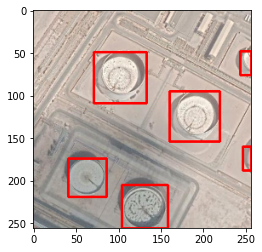

In [15]:
X_test_tmp = (X_test[0].copy())*255
contours, hierarchies = ret_contour(y_pred[0])
#         print(X_test_tmp.max())
if len(contours)>0:
    for contour, hierarchy in zip(contours, hierarchies):
#         print (hierarchy)
        if hierarchy[-1] == -1:          
            x,y,w,h = cv2.boundingRect(contour)
            cv2.rectangle(X_test_tmp,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow((X_test_tmp).astype(np.uint8))
# im_contour = Image.fromarray((X_test_tmp).astype(np.uint8))



# im_contour.save('../data/case1_tanks/output_mask_final/' + x_paths[j])

In [16]:
X_test, y_test, x_path = data_loader_pred.__getitem__(6)
y_pred = pre_trained_model.predict(X_test)

1/1 [==============================] - 5s 5s/step


In [17]:
print(hierarchies), print(len(contours))

[[ 1 -1 -1 -1]
 [ 2  0 -1 -1]
 [ 3  1 -1 -1]
 [ 4  2 -1 -1]
 [ 5  3 -1 -1]
 [-1  4 -1 -1]]
6


(None, None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


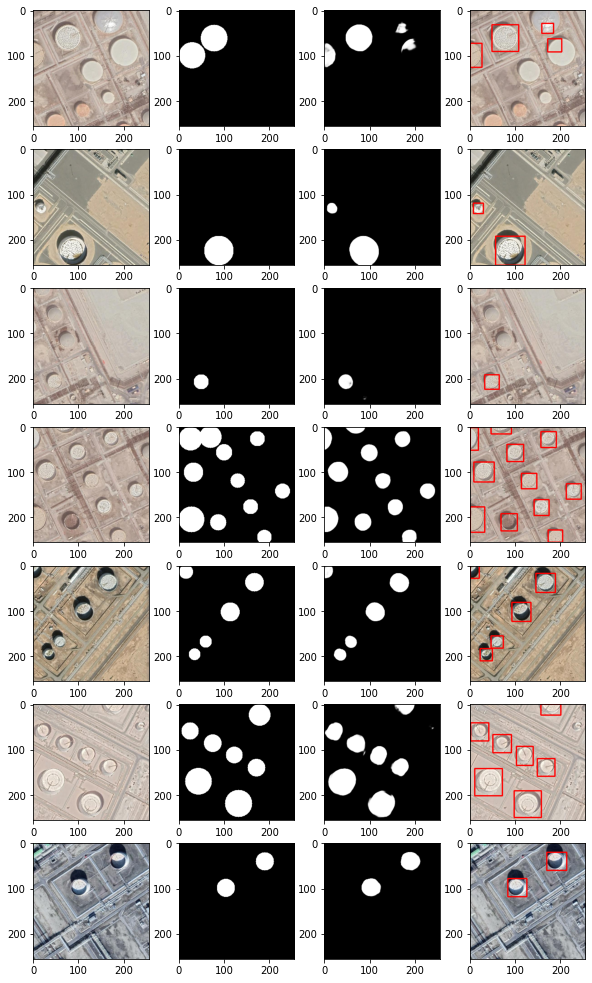

In [18]:
def plot_prediction(X_test, y_test, y_pred):
    c=1
    plt.figure(figsize=(10,20))
    for i in range(1,8):
      X_test_tmp = X_test[i].copy()
      plt.subplot(8,4,c)
      plt.imshow(X_test[i])
#       contours = ret_contour(y_pred[i])
      contours, hierarchies = ret_contour(y_pred[i])
      if len(contours)>0:
#         for contour in contours:
#           x,y,w,h = cv2.boundingRect(contour)
#           cv2.rectangle(X_test_tmp,(x,y),(x+w,y+h),(255,0,0),2)
        for contour, hierarchy in zip(contours, hierarchies):
            if hierarchy[-1] == -1 and len(contour)>10:          
                x,y,w,h = cv2.boundingRect(contour)
                cv2.rectangle(X_test_tmp,(x,y),(x+w,y+h),(255,0,0),2)
      plt.subplot(8,4,c+1)
      plt.imshow(y_test[i].reshape(256,256), cmap ='gray')
      plt.subplot(8,4,c+2)
      plt.imshow(y_pred[i].reshape(256,256), cmap ='gray')
      plt.subplot(8,4,c+3)
      plt.imshow(X_test_tmp)
      c+=4
    
plot_prediction(X_test, y_test, y_pred)

In [19]:
# import cv2 as cv
# import matplotlib.pyplot as plt

In [20]:
# #pillow rgb

# im = Image.fromarray((X_test[5]*255).astype(np.uint8))
# im.save('X_test.jpg')

In [21]:
# #saving pillow black and white

# im = Image.fromarray((y_test[0]*256).reshape(256, 256).astype(np.uint8))
# im.save('ytest.jpg')


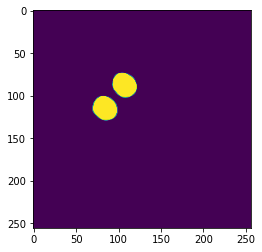

In [22]:
plt.imshow(y_pred[0])

In [23]:
# y_pred = pre_trained_model.predict(X_test)

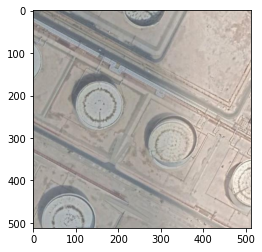

In [24]:
im_test = Image.open('../data/case1_tanks/input_image_test/97_8_4.jpg')
plt.imshow(im_test)

In [25]:
im_test_arr = np.array(im_test)/255
im_test_arr.shape

(512, 512, 3)

In [26]:
from tensorflow.image import resize

In [27]:
im_test_arr_resized = resize(im_test_arr, (256,256))
im_test_arr_resized.shape

TensorShape([256, 256, 3])

1/1 [==============================] - 0s 446ms/step


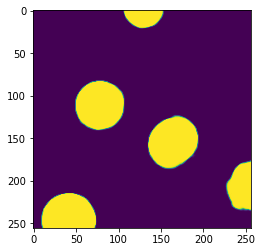

In [28]:
im_pred = pre_trained_model.predict(np.expand_dims(im_test_arr_resized, axis = 0))
im_pred[0].shape
plt.imshow(im_pred[0])

In [29]:
np.expand_dims(im_test_arr_resized, axis = 0).shape

(1, 256, 256, 3)

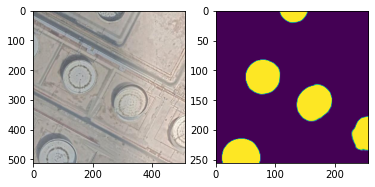

In [31]:
plt.subplot(1,2,1)
plt.imshow(im_test)

plt.subplot(1,2,2)
plt.imshow(im_pred[0])

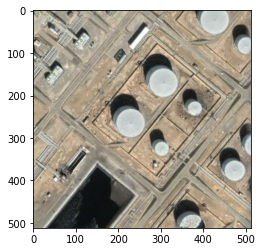

In [32]:
# loading single image for prediction

from tensorflow.image import resize
from PIL import Image
import PIL
import matplotlib.pyplot as plt

img_path = '../data/case1_tanks/input_image_test/94_5_6.jpg'
def load_test(img_path):
    im_test = Image.open(img_path)
    im_test_arr = np.array(im_test)/255
    im_test_arr_resized = resize(im_test_arr, (256,256))
    im_test_arr_resized_expand_dim = np.expand_dims(im_test_arr_resized, axis = 0)
#     plt.imshow(im_test)
    return im_test_arr_resized_expand_dim

X_test_single_img = load_test(img_path)
plt.imshow(Image.open(img_path))

In [33]:
# predicting on selected image

im_pred = pre_trained_model.predict(X_test_single_img)
im_pred = resize(im_pred, (512,512))
im_pred = im_pred[0]
# plt.imshow(im_pred)

1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 401ms/step


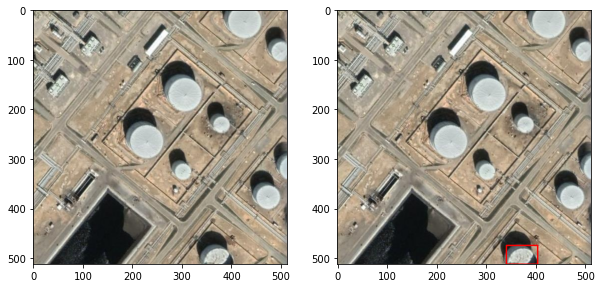

In [34]:
im_test = Image.open(img_path)
def get_final_pred_image(img_test_path):
    img_raw = np.array(Image.open(img_test_path))
#     np.stack(X)/255.
    X_test_single_img = load_test(img_test_path)
    im_pred = pre_trained_model.predict(X_test_single_img)
    im_pred = resize(im_pred, (512,512))
    im_pred = im_pred[0]
    image_8bit = np.uint8(im_pred * 255)
    ret, thresh = cv2.threshold(image_8bit, 127,255,0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)   
    if hierarchy is not None:
        contours, hierarchy = contours, hierarchy[0]
    else:
        contours, hierarchy = contours, None
    if len(contours)>0:
        for contour, hierarchy in zip(contours, hierarchy):
            if hierarchy[-1] == -1 and len(contour)>10:          
                x,y,w,h = cv2.boundingRect(contour)
                cv2.rectangle(img_raw,(x,y),(x+w,y+h),(255,0,0),2)
    return img_raw

im_pred_final = get_final_pred_image(img_path)
# plt.imshow(im_pred_final)
plt.figure(figsize=(10,20))

plt.subplot(1,2,1)
plt.imshow(im_test)

plt.subplot(1,2,2)
plt.imshow(im_pred_final)